In [ ]:
"""
Development Context:
This code was developed using Cursor editor with AI assistance. AI was primarily used for:
- Debugging and error resolution  

All architectural decisions, methodological choices, and final implementation
were critically evaluated and approved by the human developer. The AI served
as an assistant rather than an autonomous developer.
"""

import os, random, json, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from itertools import product
import time

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import joblib

# Data paths and settings
CSV_PATH = "UK20162023_modified.csv"
TARGET_COL = "demand_units"
PRODUCT_ID = 1

# Hyperparameter ranges
param_space = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.8, 0.85, 0.9],
    'max_features': ['sqrt', 'log2', 0.8]
}

# Test splits
splits = {
    'P': {'train_end': '2019-12-31', 'test_start': '2020-01-01', 'test_end': '2020-12-31'},
    'A': {'train_end': '2020-12-31', 'test_start': '2021-01-01', 'test_end': '2021-12-31'},
    'B': {'train_end': '2021-12-31', 'test_start': '2022-01-01', 'test_end': '2022-12-31'},
    'C': {'train_end': '2022-12-31', 'test_start': '2023-01-01', 'test_end': '2023-12-31'},
}

major_events = [
    'Cost-of-living Crisis', 'COVID-19 Lockdown', 'COVID-19 Second Wave',
    'Regulation 2024', 'Brexit Vote'
]

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def select_features(X, y, min_corr=0.20):
    corrs = []
    for col in X.columns:
        try:
            c, _ = spearmanr(X[col].astype(float), y.astype(float))
            c = abs(c)
            if not np.isfinite(c) or c >= 0.999:
                continue
            if c >= min_corr:
                feature_std = np.nanstd(X[col].values)
                zero_ratio = float((X[col].values == 0).mean())
                if feature_std > 1e-6 and zero_ratio < 0.9:
                    corrs.append((col, c))
        except:
            continue
    corrs.sort(key=lambda x: x[1], reverse=True)
    selected = [f for f, _ in corrs]
    return selected, corrs

def add_time_features(df):

    f = df.copy()
    f["year"] = f["week_start_date"].dt.year
    f["month"] = f["week_start_date"].dt.month
    f["weekofyear"] = f["week_start_date"].dt.isocalendar().week.astype(int)
    f["quarter"] = f["week_start_date"].dt.quarter
    
    # Cyclical encodings
    f["sin_week"] = np.sin(2 * np.pi * f["weekofyear"] / 52.0)
    f["cos_week"] = np.cos(2 * np.pi * f["weekofyear"] / 52.0)
    f["sin_month"] = np.sin(2 * np.pi * f["month"] / 12.0)
    f["cos_month"] = np.cos(2 * np.pi * f["month"] / 12.0)
    f["sin_quarter"] = np.sin(2 * np.pi * f["quarter"] / 4.0)
    f["cos_quarter"] = np.cos(2 * np.pi * f["quarter"] / 4.0)
    
    return f

def add_lags(df, target_col):
    f = df.copy()
    
    # Lags
    for L in [1, 2, 4, 12, 26]:
        f[f"lag_{L}"] = f[target_col].shift(L)
    
    # Rolling statistics
    for W in [4, 8, 12, 26]:
        f[f"roll_mean_{W}"] = f[target_col].shift(1).rolling(window=W, min_periods=max(1, W // 2)).mean()
        f[f"roll_std_{W}"] = f[target_col].shift(1).rolling(window=W, min_periods=max(1, W // 2)).std()
        f[f"roll_min_{W}"] = f[target_col].shift(1).rolling(window=W, min_periods=max(1, W // 2)).min()
        f[f"roll_max_{W}"] = f[target_col].shift(1).rolling(window=W, min_periods=max(1, W // 2)).max()
    
    # Differences
    for D in [1, 4, 12]:
        f[f"diff_{D}"] = f[target_col].diff(D)
    
    # Price features if available
    if "price_gbp" in f.columns:
        f["price_lag_1"] = f["price_gbp"].shift(1)
        f["price_roll_4"] = f["price_gbp"].shift(1).rolling(window=4, min_periods=2).mean()
        f["price_diff_1"] = f["price_gbp"].diff(1)
    
    return f

def weeks_since_event(df, date_col="week_start_date", event_col="event", events=(), start_offset=0):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    last_date = df[date_col].min() - pd.Timedelta(weeks=start_offset + 1)
    out = []
    for _, row in df.iterrows():
        cur_date = row[date_col]
        if str(row[event_col]) in events:
            last_date = cur_date
        weeks = max(0, int((cur_date - last_date).days // 7))
        out.append(weeks)
    return pd.Series(out, index=df.index)

def add_event_features(df):
    f = df.copy()
    f['event'] = f['event'].fillna('No Event')
    f['has_event'] = (f['event'] != 'No Event').astype(int)
    
    crisis_events = ['Cost-of-living Crisis', 'COVID-19 Lockdown', 'COVID-19 Second Wave']
    f['is_crisis'] = f['event'].isin(crisis_events).astype(int)
    
    regulatory_events = ['Regulation 2024', 'Brexit Vote']
    f['is_regulatory'] = f['event'].isin(regulatory_events).astype(int)
    
    return f

def seasonal_naive(y_hist, horizon, season=52):
    if len(y_hist) == 0:
        return np.zeros(horizon, dtype=float)
    if len(y_hist) < season:
        base = np.repeat(y_hist[-1], season)
    else:
        base = y_hist[-season:]
    reps = int(np.ceil(horizon / season))
    return np.tile(base, reps)[:horizon]

def mase(y_true, y_pred, y_hist, season=52):
    mae = mean_absolute_error(y_true, y_pred)
    naive = seasonal_naive(y_hist, len(y_true), season)
    mae_naive = mean_absolute_error(y_true, naive)
    return mae / mae_naive if mae_naive > 0 else np.inf

def generate_params(n_trials=30):
    combinations = []
    for _ in range(n_trials):
        params = {}
        for key, values in param_space.items():
            params[key] = random.choice(values)
        combinations.append(params)
    return combinations

def evaluate_params(X_train, y_train, params):
    try:
        tscv = TimeSeriesSplit(n_splits=3)
        fold_scores = []
        
        for tr_idx, va_idx in tscv.split(X_train):
            if len(tr_idx) < 10 or len(va_idx) < 5:
                continue
                
            X_tr, X_va = X_train[tr_idx], X_train[va_idx]
            y_tr, y_va = y_train[tr_idx], y_train[va_idx]
            
            scaler = RobustScaler()
            X_tr_scaled = scaler.fit_transform(X_tr)
            X_va_scaled = scaler.transform(X_va)
            
            model = GradientBoostingRegressor(
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf'],
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                max_features=params['max_features'],
                random_state=42
            )
            
            model.fit(X_tr_scaled, y_tr)
            val_pred = model.predict(X_va_scaled)
            val_mae = mean_absolute_error(y_va, val_pred)
            
            if np.isfinite(val_mae):
                fold_scores.append(val_mae)
        
        return float(np.mean(fold_scores)) if fold_scores else float('inf')
    
    except:
        return float('inf')

def optimize_hyperparams():
    set_seed(42)
    
    df = pd.read_csv(CSV_PATH, parse_dates=["week_start_date"])
    df = df.loc[df["product_id"] == PRODUCT_ID].sort_values("week_start_date").reset_index(drop=True)

    # Drop order_volume columns
    drop_ov = [c for c in df.columns if c.startswith("order_volume") or c == "order_volume"]
    if drop_ov:
        df = df.drop(columns=drop_ov)
    
    all_results = {}
    best_params = {}
    
    for split_name, split_config in splits.items():
        print(f"\nOptimizing split {split_name}...")
        
        # Prepare train data
        train_mask = (df["week_start_date"] >= "2016-01-01") & (df["week_start_date"] <= split_config['train_end'])
        df_train = df.loc[train_mask].reset_index(drop=True)
        
        if len(df_train) < 100:
            continue
        
        # Feature engineering
        df_train_fe = add_time_features(df_train)
        df_train_fe = add_lags(df_train_fe, TARGET_COL)
        df_train_fe = add_event_features(df_train_fe)
        df_train_fe['weeks_since_major_event'] = weeks_since_event(
            df_train_fe, events=major_events, start_offset=0)
        
        # Clean data
        obj_cols = [c for c in df_train_fe.columns if df_train_fe[c].dtype == 'O']
        if obj_cols:
            df_train_fe = df_train_fe.drop(columns=obj_cols)
        
        lag_cols = [c for c in df_train_fe.columns if c.startswith(('lag_', 'roll_', 'price_lag_', 'diff_'))]
        df_train_fe = df_train_fe.dropna(subset=lag_cols).reset_index(drop=True)
        
        # Prepare features
        numeric_cols = [c for c in df_train_fe.columns if c == TARGET_COL or np.issubdtype(df_train_fe[c].dtype, np.number)]
        train_num = df_train_fe[numeric_cols].copy()
        
        drop_cols = ["week_start_date", "product_id", TARGET_COL]
        all_feats = [c for c in train_num.columns if c not in drop_cols]
        all_feats = [f for f in all_feats if not f.startswith("order_volume")]
        
        # Generate and test parameters
        param_combinations = generate_params(30)
        trial_results = []
        
        for hyperparams in param_combinations:
            try:
                # Feature selection
                X_train_all = train_num[all_feats].values.astype(np.float32)
                y_train_all = train_num[TARGET_COL].values.astype(np.float32)
                
                mask = ~(np.isnan(X_train_all).any(axis=1) | np.isnan(y_train_all))
                X_train_clean = X_train_all[mask]
                y_train_clean = y_train_all[mask]
                
                selected_features, _ = select_features(
                    pd.DataFrame(X_train_clean, columns=all_feats),
                    y_train_clean,
                    min_corr=0.20
                )
                
                if len(selected_features) < 3:
                    continue
                
                X_train_raw = train_num[selected_features].values.astype(np.float32)
                y_train = train_num[TARGET_COL].values.astype(np.float32)
                
                score = evaluate_params(X_train_raw, y_train, hyperparams)
                
                trial_results.append({
                    'hyperparams': hyperparams,
                    'cv_score': float(score),
                    'n_features': len(selected_features)
                })
                
            except:
                continue
        
        # Sort and save results
        trial_results.sort(key=lambda x: x['cv_score'])
        
        if trial_results:
            best_params[split_name] = trial_results[0]['hyperparams']
            all_results[split_name] = {
                'best_score': trial_results[0]['cv_score'],
                'best_params': trial_results[0]['hyperparams'],
                'all_results': trial_results
            }
            
            print(f"Best score: {trial_results[0]['cv_score']:.4f}")
    
    # Save results
    final_results = {
        'best_params_per_split': best_params,
        'detailed_results': all_results
    }
    
    with open('gbm_hyperopt_results.json', 'w') as f:
        json.dump(final_results, f, indent=2)
    
    return final_results

def train_models():
    try:
        with open('gbm_hyperopt_results.json', 'r') as f:
            hyperopt_results = json.load(f)
        optimized_params = hyperopt_results['best_params_per_split']
    except FileNotFoundError:
        print("No optimized parameters found, running optimization first...")
        hyperopt_results = optimize_hyperparams()
        optimized_params = hyperopt_results['best_params_per_split']
    
    set_seed(42)
    
    df = pd.read_csv(CSV_PATH, parse_dates=["week_start_date"])
    df = df.loc[df["product_id"] == PRODUCT_ID].sort_values("week_start_date").reset_index(drop=True)

    # Drop order_volume columns
    drop_ov = [c for c in df.columns if c.startswith("order_volume") or c == "order_volume"]
    if drop_ov:
        df = df.drop(columns=drop_ov)
    
    final_results = {}
    
    for split_name, split_config in splits.items():
        if split_name not in optimized_params or not optimized_params[split_name]:
            params = {
                'n_estimators': 200,
                'max_depth': 4,
                'min_samples_leaf': 2,
                'learning_rate': 0.05,
                'subsample': 0.85,
                'max_features': 'sqrt'
            }
        else:
            params = optimized_params[split_name]
        
        print(f"\nTraining split {split_name}...")

        # Prepare train and test data
        train_mask = (df["week_start_date"] >= "2016-01-01") & (df["week_start_date"] <= split_config['train_end'])
        test_mask = (df["week_start_date"] >= split_config['test_start']) & (df["week_start_date"] <= split_config['test_end'])

        df_train = df.loc[train_mask].reset_index(drop=True)
        df_test = df.loc[test_mask].reset_index(drop=True)

        if len(df_test) == 0:
            continue

        # Feature engineering
        df_train_fe = add_time_features(df_train)
        df_train_fe = add_lags(df_train_fe, TARGET_COL)
        df_train_fe = add_event_features(df_train_fe)
        df_test_fe = add_time_features(df_test)
        df_test_fe = add_lags(df_test_fe, TARGET_COL)
        df_test_fe = add_event_features(df_test_fe)

        # Event features with memory across boundary
        df_train_fe['weeks_since_major_event'] = weeks_since_event(
            df_train_fe, events=major_events, start_offset=0)
        last_offset = int(df_train_fe['weeks_since_major_event'].iloc[-1])
        df_test_fe['weeks_since_major_event'] = weeks_since_event(
            df_test_fe, events=major_events, start_offset=last_offset)

        for frame in [df_train_fe, df_test_fe]:
            obj_cols = [c for c in frame.columns if frame[c].dtype == 'O']
            if obj_cols:
                frame.drop(columns=obj_cols, inplace=True)

        lag_cols = [c for c in df_train_fe.columns if c.startswith(('lag_', 'roll_', 'price_lag_', 'diff_'))]
        df_train_fe = df_train_fe.dropna(subset=lag_cols).reset_index(drop=True)
        df_test_fe = df_test_fe.dropna(subset=lag_cols).reset_index(drop=True)

        # Train/Val split (15% for validation)
        val_size = max(8, int(len(df_train_fe) * 0.15))
        df_train_split = df_train_fe.iloc[:-val_size].copy()
        df_val_split = df_train_fe.iloc[-val_size:].copy()


        numeric_cols = [c for c in df_train_split.columns if c == TARGET_COL or np.issubdtype(df_train_split[c].dtype, np.number)]
        train_num = df_train_split[numeric_cols].copy()
        val_num = df_val_split[numeric_cols].copy()
        test_num = df_test_fe[numeric_cols].copy()

        drop_cols = ["week_start_date", "product_id", TARGET_COL]
        all_feats = [c for c in train_num.columns if c not in drop_cols]
        all_feats = [f for f in all_feats if not f.startswith("order_volume")]

        # Apply feature selection
        X_train_all = train_num[all_feats].values.astype(np.float32)
        y_train_all = train_num[TARGET_COL].values.astype(np.float32)
        mask = ~(np.isnan(X_train_all).any(axis=1) | np.isnan(y_train_all))
        X_train_clean = X_train_all[mask]
        y_train_clean = y_train_all[mask]

        selected_features, feature_corrs = select_features(
            pd.DataFrame(X_train_clean, columns=all_feats),
            y_train_clean,
            min_corr=0.20
        )

        # Prepare matrices
        X_train = train_num[selected_features].values.astype(np.float32)
        X_val = val_num[selected_features].values.astype(np.float32)
        X_test = test_num[selected_features].values.astype(np.float32)
        y_train = train_num[TARGET_COL].values.astype(np.float32)
        y_val = val_num[TARGET_COL].values.astype(np.float32)
        y_test = test_num[TARGET_COL].values.astype(np.float32)

        # Scale data
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # Train model
        model = GradientBoostingRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            max_features=params['max_features'],
            random_state=42
        )
        
        model.fit(X_train_scaled, y_train)

        # val
        val_pred = model.predict(X_val_scaled)
        val_pred = np.maximum(val_pred, 0)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_mape = mean_absolute_percentage_error(y_val, val_pred) * 100.0

        #test
        test_pred = model.predict(X_test_scaled)
        test_pred = np.maximum(test_pred, 0)
        test_mae = mean_absolute_error(y_test, test_pred)
        test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100.0

        naive1 = np.concatenate([[y_train[-1]], y_test[:-1]])
        naive1_mae = mean_absolute_error(y_test, naive1)
        naive52 = seasonal_naive(y_train, len(y_test), season=52)
        naive52_mae = mean_absolute_error(y_test, naive52)
        mase_score = mase(y_test, test_pred, y_train, season=52)

        test_df_out = df_test_fe.copy().reset_index(drop=True)
        test_df_out["y_true"] = y_test
        test_df_out["y_pred"] = test_pred
        test_df_out["abs_err"] = abs(test_df_out["y_true"] - test_df_out["y_pred"])
        test_df_out.to_csv(f"gbm_test_preds_{split_name}.csv", index=False)
        
        joblib.dump(model, f"gbm_model_final_{split_name}.joblib")
        joblib.dump(scaler, f"gbm_scaler_{split_name}.joblib")

        # Feature importance
        feature_importance = sorted(zip(selected_features, model.feature_importances_), 
                                  key=lambda x: x[1], reverse=True)[:10]

        # Store results
        final_results[split_name] = {
            'split_name': split_name,
            'optimized_params': params,
            'train_rows': len(df_train_fe),
            'test_rows': len(df_test_fe),
            'selected_features': len(selected_features),
            'total_features': len(all_feats),
            'val_mae': float(val_mae),
            'val_mape': float(val_mape),
            'test_mae': float(test_mae),
            'test_mape': float(test_mape),
            'test_naive1_mae': float(naive1_mae),
            'test_naive52_mae': float(naive52_mae),
            'test_mase': float(mase_score),
            'top_features': [f[0] for f in feature_importance[:5]],
            'feature_importances': {f[0]: float(f[1]) for f in feature_importance}
        }

        print(f"Test MAE: {test_mae:.3f} | MAPE: {test_mape:.2f}% | MASE: {mase_score:.3f}")

    # Save results
    with open('gbm_final_results.json', 'w') as f:
        json.dump(final_results, f, indent=2)
    
    return final_results

# Run the full pipeline
if __name__ == "__main__":
    print("Gradient Boosting Analysis")
    
    # Run hyperparameter optimization
    hyperopt_results = optimize_hyperparams()
    
    # Train final models
    final_results = train_models()
        
  

Gradient Boosting Hyperparameter Optimization
Running full pipeline: hyperparameter optimization + final training
Dropping columns (leakage): ['order_volume']

HYPERPARAMETER OPTIMIZATION FOR SPLIT P
Train: 2016-2019 → Test: 2020
Training data shape after FE: (497, 54)
Available features: 51
Generated 30 hyperparameter combinations (random search)

Starting hyperparameter search with 30 combinations...

Trial 1/30: {'n_estimators': 300, 'max_depth': 3, 'min_samples_leaf': 1, 'learning_rate': 0.05, 'subsample': 0.8, 'max_features': 'sqrt'}
  CV Score: 6.4370 | Features: 30 | Time: 0.3s
  *** NEW BEST SCORE: 6.4370 ***

Trial 2/30: {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'max_features': 'sqrt'}
  CV Score: 6.3436 | Features: 30 | Time: 0.1s
  *** NEW BEST SCORE: 6.3436 ***

Trial 3/30: {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 2, 'learning_rate': 0.01, 'subsample': 0.9, 'max_features': 'sqrt'}
  CV Score: 13.411

Found prediction files for splits: ['P', 'A', 'B', 'C']


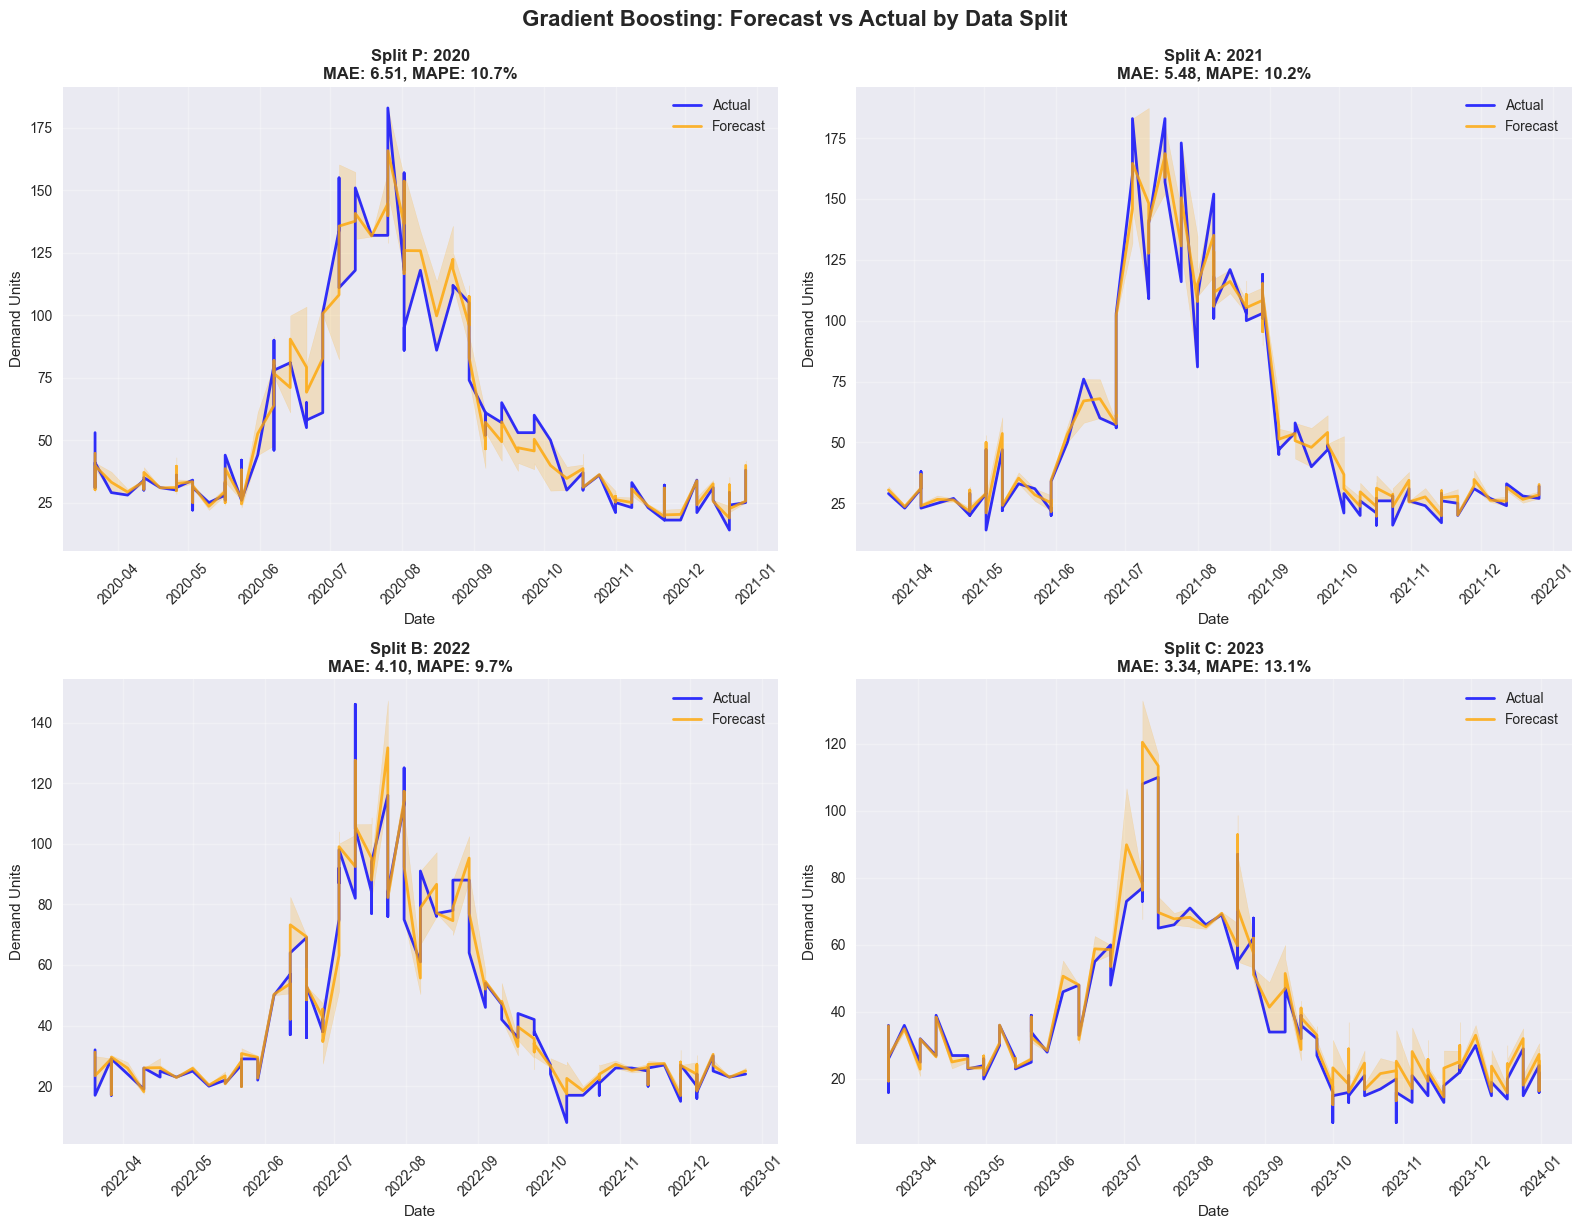

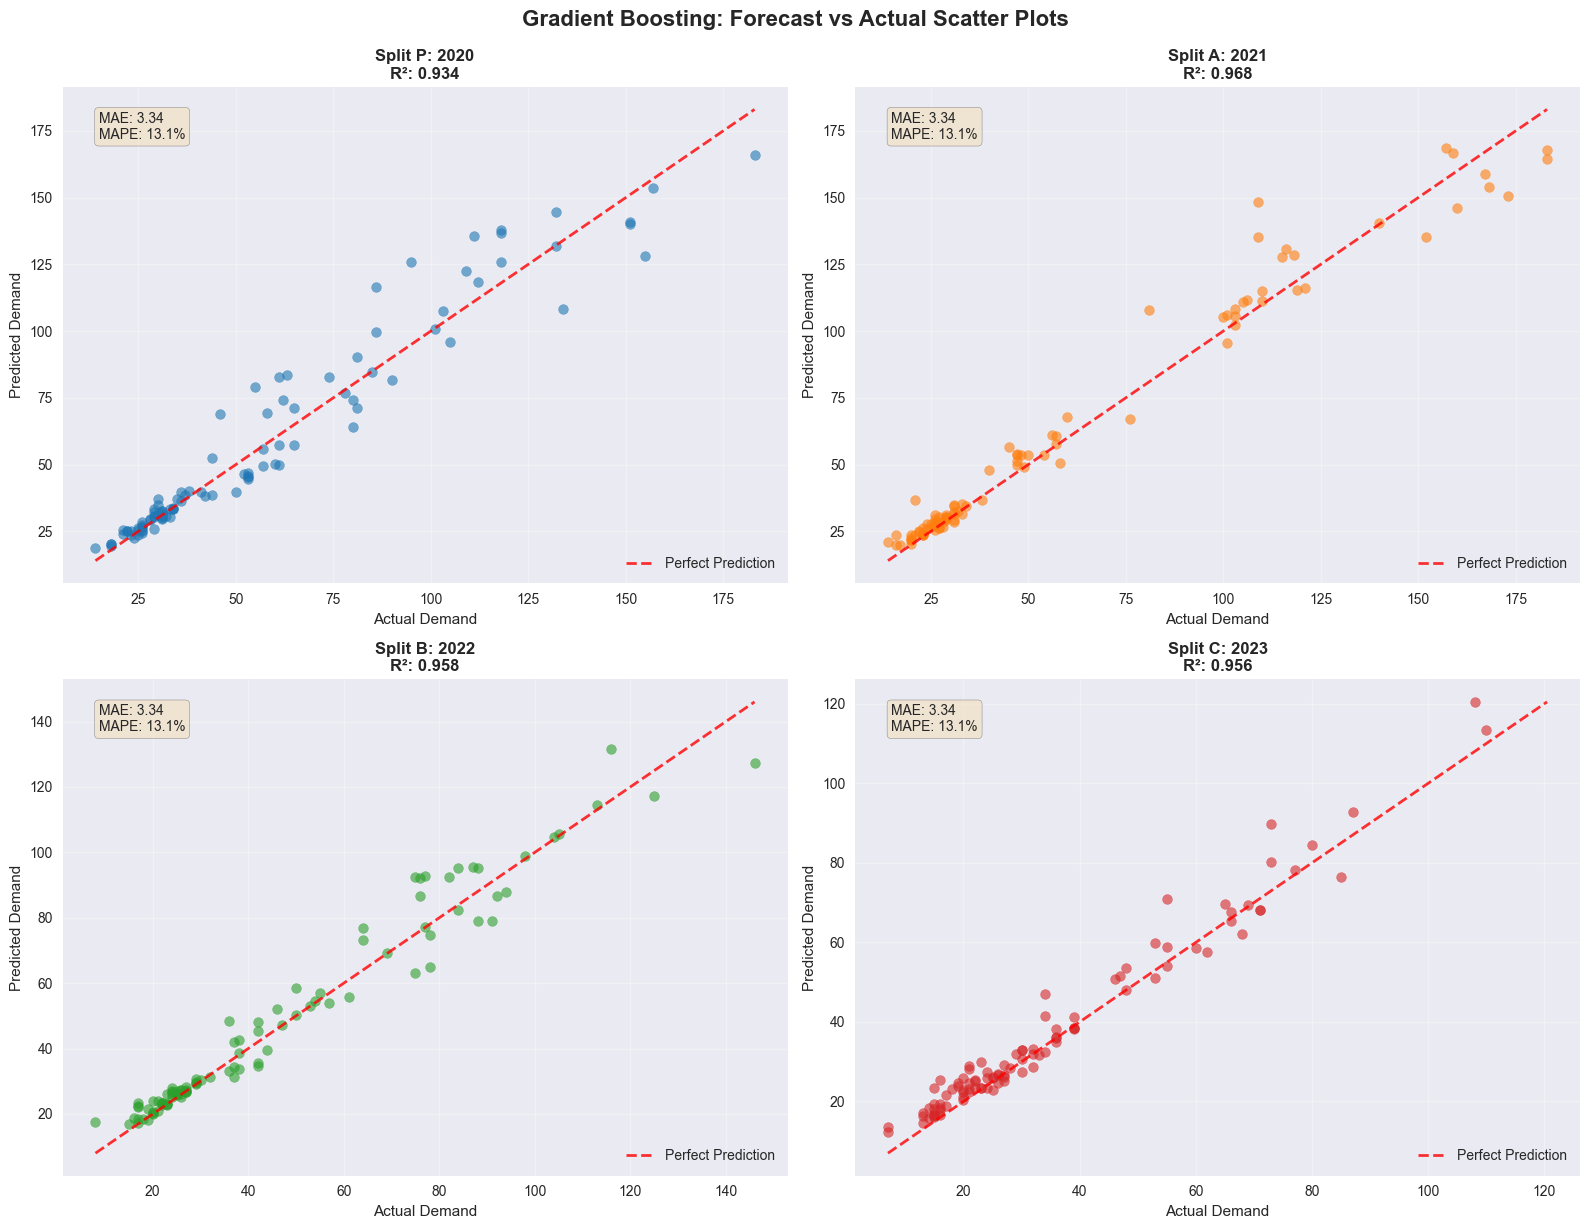


PERFORMANCE SUMMARY BY SPLIT
Split Period   MAE   MAPE  Test_Points
    P   2020 6.508 10.733          102
    A   2021 5.478 10.180           94
    B   2022 4.097  9.734           98
    C   2023 3.342 13.107          100


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import r2_score

def plot_results():
    """Plot forecast vs actual results"""
    splits = {
        'P': '2020',
        'A': '2021', 
        'B': '2022',
        'C': '2023'
    }
    
    # Check which prediction files exist
    available_splits = []
    for split_name in splits.keys():
        pred_file = f"gbm_test_preds_{split_name}.csv"
        if Path(pred_file).exists():
            available_splits.append(split_name)
        else:
            print(f"Warning: {pred_file} not found")
    
    if not available_splits:
        print("No prediction files found. Please run the model training first.")
        return
    
    # Time series plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    metrics_summary = []
    
    for idx, split_name in enumerate(available_splits):
        if idx >= 4:
            break
            
        # Load predictions
        df_pred = pd.read_csv(f"gbm_test_preds_{split_name}.csv")
        df_pred['week_start_date'] = pd.to_datetime(df_pred['week_start_date'])
        
        # Calculate metrics
        mae = np.mean(df_pred['abs_err'])
        mape = np.mean(np.abs((df_pred['y_true'] - df_pred['y_pred']) / df_pred['y_true'])) * 100
        
        metrics_summary.append({
            'Split': split_name,
            'Period': splits[split_name],
            'MAE': mae,
            'MAPE': mape,
            'Test_Points': len(df_pred)
        })
        
        # Plot time series
        ax = axes[idx]
        ax.plot(df_pred['week_start_date'], df_pred['y_true'], 
                label='Actual', linewidth=2, color='blue', alpha=0.8)
        ax.plot(df_pred['week_start_date'], df_pred['y_pred'], 
                label='Forecast', linewidth=2, color='orange', alpha=0.8)
        
        ax.set_title(f'Split {split_name}: {splits[split_name]} - MAE: {mae:.2f}, MAPE: {mape:.1f}%')
        ax.set_xlabel('Date')
        ax.set_ylabel('Demand Units')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for idx in range(len(available_splits), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, split_name in enumerate(available_splits):
        if idx >= 4:
            break
            
        df_pred = pd.read_csv(f"gbm_test_preds_{split_name}.csv")
        ax = axes[idx]
        
        # Scatter plot
        ax.scatter(df_pred['y_true'], df_pred['y_pred'], alpha=0.6, s=50)
        
        # Perfect prediction line
        min_val = min(df_pred['y_true'].min(), df_pred['y_pred'].min())
        max_val = max(df_pred['y_true'].max(), df_pred['y_pred'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        # Calculate R²
        r2 = r2_score(df_pred['y_true'], df_pred['y_pred'])
        
        ax.set_title(f'Split {split_name}: {splits[split_name]} - R²: {r2:.3f}')
        ax.set_xlabel('Actual Demand')
        ax.set_ylabel('Predicted Demand')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(available_splits), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    metrics_df = pd.DataFrame(metrics_summary)
    print("\nPerformance Summary:")
    print(metrics_df.to_string(index=False, float_format='%.3f'))
    
    return metrics_df

# Run the visualization
metrics_summary = plot_results()


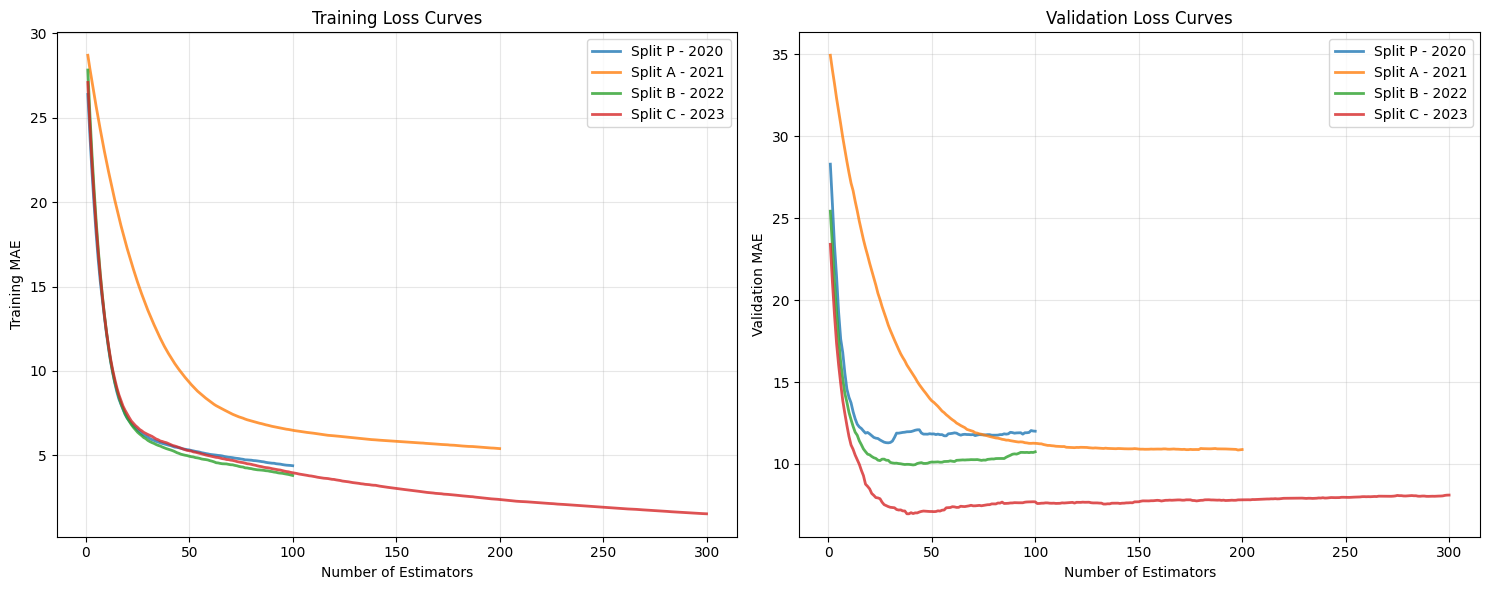

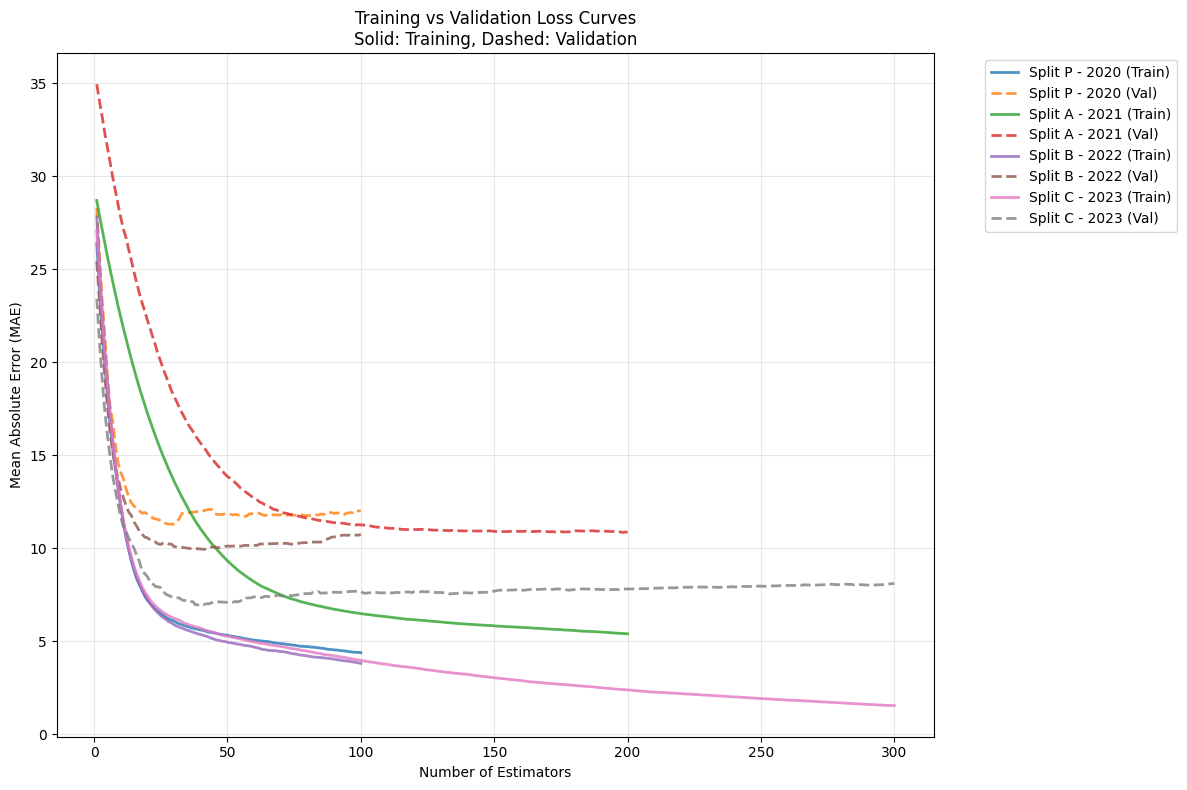


Loss Curves Summary:

Split P - 2020:
  Final Training MAE: 4.3879
  Final Validation MAE: 11.9994
  Overfitting Gap: 7.6115
  Best Validation at iteration 29: 11.2885

Split A - 2021:
  Final Training MAE: 5.4022
  Final Validation MAE: 10.8799
  Overfitting Gap: 5.4777
  Best Validation at iteration 198: 10.8505

Split B - 2022:
  Final Training MAE: 3.8091
  Final Validation MAE: 10.7407
  Overfitting Gap: 6.9316
  Best Validation at iteration 41: 9.9398

Split C - 2023:
  Final Training MAE: 1.5409
  Final Validation MAE: 8.1006
  Overfitting Gap: 6.5596
  Best Validation at iteration 39: 6.9583


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from scipy.stats import spearmanr

def plot_loss_curves():
    """Plot training and validation loss curves"""
    splits = {
        'P': '2020',
        'A': '2021', 
        'B': '2022',
        'C': '2023'
    }
    

    if not Path('gbm_final_results.json').exists():
        print("Results file not found. Please run the model training first.")
        return
    

    with open('gbm_final_results.json', 'r') as f:
        results = json.load(f)
    
    # Load data
    df = pd.read_csv("UK20162023_modified.csv", parse_dates=["week_start_date"])
    df = df.loc[df["product_id"] == 1].sort_values("week_start_date").reset_index(drop=True)
    
    # Drop order_volume columns
    drop_ov = [c for c in df.columns if c.startswith("order_volume") or c == "order_volume"]
    if drop_ov:
        df = df.drop(columns=drop_ov)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    all_train_losses = {}
    all_val_losses = {}
    
    for split_name, year in splits.items():
        if split_name not in results:
            continue
        
        params = results[split_name]['optimized_params']
        
        # Prepare data
        train_end = f"{year}-12-31"
        train_mask = (df["week_start_date"] >= "2016-01-01") & (df["week_start_date"] <= train_end)
        df_train = df.loc[train_mask].reset_index(drop=True)
        
        if len(df_train) < 100:
            continue
        
        # Simple feature engineering
        df_train["year"] = df_train["week_start_date"].dt.year
        df_train["month"] = df_train["week_start_date"].dt.month
        df_train["weekofyear"] = df_train["week_start_date"].dt.isocalendar().week.astype(int)
        
        for L in [1, 2, 4, 12, 26]:
            df_train[f"lag_{L}"] = df_train["demand_units"].shift(L)
        for W in [4, 8, 12, 26]:
            df_train[f"roll_mean_{W}"] = df_train["demand_units"].shift(1).rolling(window=W, min_periods=max(1, W // 2)).mean()
        
        obj_cols = [c for c in df_train.columns if df_train[c].dtype == 'O']
        if obj_cols:
            df_train = df_train.drop(columns=obj_cols)
        
        lag_cols = [c for c in df_train.columns if c.startswith(('lag_', 'roll_'))]
        df_train = df_train.dropna(subset=lag_cols).reset_index(drop=True)
        
        val_size = max(8, int(len(df_train) * 0.15))
        df_train_split = df_train.iloc[:-val_size].copy()
        df_val_split = df_train.iloc[-val_size:].copy()
        
        numeric_cols = [c for c in df_train_split.columns if c == "demand_units" or np.issubdtype(df_train_split[c].dtype, np.number)]
        train_num = df_train_split[numeric_cols].copy()
        val_num = df_val_split[numeric_cols].copy()
        
        drop_cols = ["week_start_date", "product_id", "demand_units"]
        all_feats = [c for c in train_num.columns if c not in drop_cols]
        all_feats = [f for f in all_feats if not f.startswith("order_volume")]
        
        corrs = []
        for col in all_feats:
            try:
                c, _ = spearmanr(train_num[col].astype(float), train_num["demand_units"].astype(float))
                c = abs(c)
                if np.isfinite(c) and c < 0.999:
                    corrs.append((col, c))
            except:
                continue
        corrs.sort(key=lambda x: x[1], reverse=True)
        selected_features = [f for f, _ in corrs[:20]]
        
        if len(selected_features) < 3:
            continue
        
        X_train = train_num[selected_features].values.astype(np.float32)
        X_val = val_num[selected_features].values.astype(np.float32)
        y_train = train_num["demand_units"].values.astype(np.float32)
        y_val = val_num["demand_units"].values.astype(np.float32)
        
        # Scale data
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model
        model = GradientBoostingRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            max_features=params['max_features'],
            random_state=42
        )
        
        model.fit(X_train_scaled, y_train)
        
        # Get loss curves
        train_losses = []
        val_losses = []
        
        train_staged_preds = list(model.staged_predict(X_train_scaled))
        val_staged_preds = list(model.staged_predict(X_val_scaled))
        
        for i in range(len(train_staged_preds)):
            train_mae = mean_absolute_error(y_train, train_staged_preds[i])
            val_mae = mean_absolute_error(y_val, val_staged_preds[i])
            train_losses.append(train_mae)
            val_losses.append(val_mae)
        
        # Store losses
        all_train_losses[split_name] = train_losses
        all_val_losses[split_name] = val_losses
        
        # Plot
        ax1.plot(range(1, len(train_losses) + 1), train_losses, 
                linewidth=2, alpha=0.8, label=f'Split {split_name} - {year}')
        ax2.plot(range(1, len(val_losses) + 1), val_losses, 
                linewidth=2, alpha=0.8, label=f'Split {split_name} - {year}')
    
    ax1.set_xlabel('Number of Estimators')
    ax1.set_ylabel('Training MAE')
    ax1.set_title('Training Loss Curves')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.set_xlabel('Number of Estimators')
    ax2.set_ylabel('Validation MAE')
    ax2.set_title('Validation Loss Curves')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    for split_name in all_train_losses.keys():
        year = splits[split_name]
        
        # Training loss
        ax.plot(range(1, len(all_train_losses[split_name]) + 1), all_train_losses[split_name], 
                linewidth=2, alpha=0.8, linestyle='-',
                label=f'Split {split_name} - {year} (Train)')
        
        # Validation loss
        ax.plot(range(1, len(all_val_losses[split_name]) + 1), all_val_losses[split_name], 
                linewidth=2, alpha=0.8, linestyle='--',
                label=f'Split {split_name} - {year} (Val)')
    
    ax.set_xlabel('Number of Estimators')
    ax.set_ylabel('Mean Absolute Error (MAE)')
    ax.set_title('Training vs Validation Loss Curves\nSolid: Training, Dashed: Validation')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\nLoss Curves Summary:")
    for split_name in all_train_losses.keys():
        train_losses = all_train_losses[split_name]
        val_losses = all_val_losses[split_name]
        
        print(f"\nSplit {split_name} - {splits[split_name]}:")
        print(f"  Final Training MAE: {train_losses[-1]:.4f}")
        print(f"  Final Validation MAE: {val_losses[-1]:.4f}")
        print(f"  Overfitting Gap: {val_losses[-1] - train_losses[-1]:.4f}")
        
        best_val_idx = np.argmin(val_losses)
        print(f"  Best Validation at iteration {best_val_idx + 1}: {val_losses[best_val_idx]:.4f}")
    
    return all_train_losses, all_val_losses

# Run the loss curves visualization
train_losses, val_losses = plot_loss_curves()


In [ ]:
# This cell is intentionally left empty
